# Preparations

In [1]:
import sys
import math
import numpy as np

%matplotlib inline
import matplotlib.colors
import matplotlib.pyplot as plt

sys.path.append('..')
from higgs_inference import settings

In [12]:
colors     = ['darkgreen','c', '#be96ff', '#CC002E']*2
linestyles = ['--', ':', '-.', '--']*2

scatter_alpha = 1.

def lighter_color(color, fraction_white=0.5):
    rgb = np.asarray(matplotlib.colors.to_rgb(color))
    white = np.asarray((1.,1.,1.))
    return fraction_white * white + (1. - fraction_white)*rgb

In [3]:
margin_l_absolute = 8. * 0.1
margin_r_absolute = 8. * 0.02
margin_sep_absolute = 8. * 0.02
margin_t_absolute = 8. * 0.02
margin_b_absolute = 8. * 0.08

def calculate_height(n_panels=2, width=8.):
    
    # Calculate horizontal margins. Units: relative to width.
    margin_l = margin_l_absolute / width
    margin_r = margin_r_absolute / width
    margin_l_subsequent = margin_l
    if n_panels > 2:
        margin_l_subsequent = margin_r
    margin_sep = margin_sep_absolute / width
    if n_panels > 2:
        margin_sep = 0
    margin_sep_total = margin_r + margin_sep + margin_l_subsequent
    panel_width = (1. - margin_l - margin_r - (n_panels - 1)*margin_sep_total) / n_panels
    
    # Calculate wspace argument of subplots_adjust
    wspace = margin_sep_total / panel_width
    
    # Calculate absolute height
    panel_height_absolute = panel_width * width # Square plots
    
    # Calculate horizontal margins. Units: relative to width.
    height = panel_height_absolute + margin_t_absolute + margin_b_absolute
    panel_height = panel_height_absolute / height
    margin_t = margin_t_absolute / height
    margin_b = margin_b_absolute / height
    
    # Return height
    return height


def adjust_margins(n_panels=2, width=8.):
    
    # Calculate horizontal margins. Units: relative to width.
    margin_l = margin_l_absolute / width
    margin_r = margin_r_absolute / width
    margin_l_subsequent = margin_l
    if n_panels > 2:
        margin_l_subsequent = margin_r
    margin_sep = margin_sep_absolute / width
    if n_panels > 2:
        margin_sep = 0
    margin_sep_total = margin_r + margin_sep + margin_l_subsequent
    panel_width = (1. - margin_l - margin_r - (n_panels - 1)*margin_sep_total) / n_panels
    
    # Calculate wspace argument of subplots_adjust
    wspace = margin_sep_total / panel_width
    
    # Calculate absolute height
    panel_height_absolute = panel_width * width # Square plots
    
    # Calculate horizontal margins. Units: relative to width.
    height = panel_height_absolute + margin_t_absolute + margin_b_absolute
    panel_height = panel_height_absolute / height
    margin_t = margin_t_absolute / height
    margin_b = margin_b_absolute / height
    
    # Set margins
    plt.subplots_adjust(left = margin_l,
                        right = 1. - margin_r,
                        bottom = margin_b,
                        top = 1. - margin_t,
                        wspace = wspace)
    
print(calculate_height(2,8.))
print(calculate_height(3,8.))

3.7600000000000002
2.9333333333333336


# Data

In [9]:
metrics_filenames = [#'loss',
                     'mse_logr',
                     'ce',
                     'mse_scores']
metrics_labels = [#'Loss',
                  r'MSE on $\log \ r$',
                  'Cross entropy',
                  'MSE scores']
n_metrics = len(metrics_filenames)
metrics_log = [#True,
               False,
               False,
               False]
metrics_min = [#None,
               0., #-0.01,
               0.6568,
               -0.1]
metrics_max = [#None,
               0.225,
               0.6705,
               7.5]
metrics_optimal = [#0.,
                   0.,
                   0.657932534292,
                   0.]
metrics_histo = [#None,
                 0.212746934642,
                 0.669543745169,
                 None]

strategies_filenames = ['carl_shallow',
                        'regression',
                        'combined_deep',
                        'combinedregression_deep',
                        'carl_smeared',
                        'regression_smeared',
                        'combined_smeared',
                        'combinedregression_smeared']
strategies_folders = ['parameterized'] * len(strategies_filenames)
strategies_labels = ['CARL',
                     'ROLR',
                     'CASCAL',
                     'RASCAL',
                     'CARL',
                     'ROLR',
                     'CASCAL',
                     'RASCAL']
strategies_panel = [0, 0, 0, 0,
                   1, 1, 1, 1]
n_panels = max(strategies_panel) + 1


In [5]:
metrics = []  # Indexed by [strategy][metric][train/validation][epoch]
detailed_metrics = []  # Indexed by [strategy][metric][batch] (only available on train)
result_dir = '../results'

for sfile, sfolder in zip(strategies_filenames, strategies_folders):
    line1 = []
    line2 = []
    for met in metrics_filenames:
        line1.append(np.load(result_dir + '/' + sfolder + '/traininghistory_' + met + '_' + sfile + '.npy') )
        line2.append(np.load(result_dir + '/' + sfolder + '/traininghistory_100batches_' + met + '_' + sfile + '.npy') )
    metrics.append(line1)
    detailed_metrics.append(line2)
    

In [6]:
n_reduce = 30
coarsegrained_detailed_metrics = []

for strategy_results in detailed_metrics:
    
    coarsegrained_strategy_results = []
    
    for metric_results in strategy_results:
        
        coarsegrained_metric_results = []
        
        n_batches = len(metric_results)

        lower = - n_reduce
        upper = 0

        while upper < n_batches:
            lower += n_reduce
            upper += n_reduce
            coarsegrained_metric_results.append(np.mean(metric_results[lower:upper]))
            
        coarsegrained_metric_results = np.asarray(coarsegrained_metric_results)
        coarsegrained_strategy_results.append(coarsegrained_metric_results)
        
    coarsegrained_detailed_metrics.append(coarsegrained_strategy_results)
        

# Paper plot

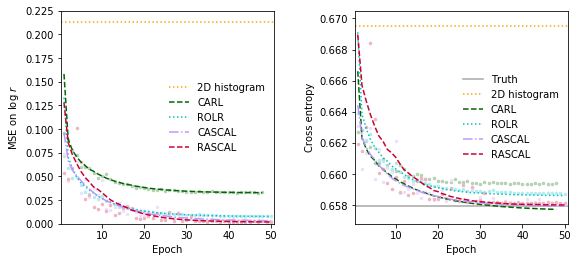

In [22]:
plt.figure(figsize=(8., calculate_height(2,8.)))

for m in range(2):
    
    plt.subplot(1, 2, m+1)

    if m > 0:
        plt.plot([0.25,50.75], [metrics_optimal[m], metrics_optimal[m]], ls='-', lw=1.5, c='0.65',
                 label='Truth')
    plt.plot([0.25,50.75], [metrics_histo[m], metrics_histo[m]], ls=':', lw=1.5, c='orange',
            label='2D histogram')
        
    # Validation set
    i = 0
    for s, (spanel, slabel) in enumerate(zip(strategies_panel, strategies_labels)):
        if spanel != 0:
            continue
        n_epochs = len(metrics[s][m][0])
        n_batches = len(coarsegrained_detailed_metrics[s][m])
        _y = metrics[s][m][1]
        _x = np.array(list(range(len(_y)))) + 1
        plt.plot(_x, _y, c=lighter_color(colors[i],0.7), marker='.', ms=5., ls='', alpha=1.)
        i += 1

    # Training data
    i = 0
    for s, (spanel, slabel) in enumerate(zip(strategies_panel, strategies_labels)):
        if spanel != 0:
            continue
        n_epochs = len(metrics[s][m][0])
        n_batches = len(coarsegrained_detailed_metrics[s][m])
        _y = metrics[s][m][0]
        _x = np.linspace(1., n_epochs, n_epochs)
        plt.plot(_x, _y, c=colors[i], lw=1.5, ls=linestyles[s], label=slabel)
        i += 1

    plt.legend(frameon=False)

    if metrics_log[m]:
        plt.yscale('log')
    plt.ylim(metrics_min[m], metrics_max[m])
    plt.xlim(0.25,50.75)

    plt.xlabel('Epoch')
    plt.ylabel(metrics_labels[m])

adjust_margins(2,8.)
plt.savefig('../figures/learning_curves.pdf')

# More results

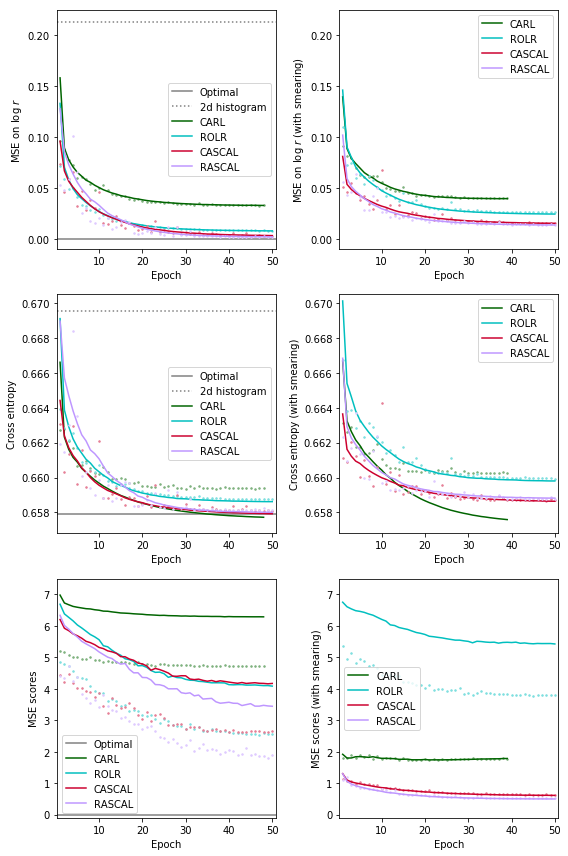

In [8]:
plt.figure(figsize=(n_panels*4., n_metrics*4))

for p in range(n_panels):

    for m, mlabel in enumerate(metrics_labels):
        
        plt.subplot(n_metrics, n_panels, m * n_panels + p + 1)
        
        if False:
            i = 0
            for s, (spanel, slabel) in enumerate(zip(strategies_panel, strategies_labels)):
                if spanel != p:
                    continue

                n_epochs = len(metrics[s][m][0])
                n_batches = len(coarsegrained_detailed_metrics[s][m])

                # Per-batch training data
                _y = coarsegrained_detailed_metrics[s][m]
                _x = np.linspace(0.5, n_epochs + 0.5, n_batches)
                plt.plot(_x, _y, c=lighter_color(colors[i]), marker='.', ms=3., ls='', alpha=1.)

                i += 1
                
        if p == 0:
            plt.plot([0.25,50.75], [metrics_optimal[m], metrics_optimal[m]], ls='-', lw=1.5, c='0.5',
                    label='Optimal')
            
        if p==0 and metrics_histo[m] is not None:
            plt.plot([0.25,50.75], [metrics_histo[m], metrics_histo[m]], ls=':', lw=1.5, c='0.5',
                    label='2d histogram')
        
        i = 0
        for s, (spanel, slabel) in enumerate(zip(strategies_panel, strategies_labels)):
            if spanel != p:
                continue
                
            n_epochs = len(metrics[s][m][0])
            n_batches = len(coarsegrained_detailed_metrics[s][m])

            # Validation set
            _y = metrics[s][m][1]
            _x = np.array(list(range(len(_y)))) + 1
            #plt.plot(_x, _y, c=colors[i], lw=1.5, ls='--')
            plt.plot(_x, _y, c=lighter_color(colors[i]), marker='.', ms=3., ls='', alpha=1.)
                
            # Training data
            _y = metrics[s][m][0]
            _x = np.linspace(1., n_epochs, n_epochs)
            plt.plot(_x, _y, c=colors[i], lw=1.5, ls='-', label=slabel)
            
            i += 1
        
        plt.legend()
        
        if metrics_log[m]:
            plt.yscale('log')
        plt.ylim(metrics_min[m],metrics_max[m])
        plt.xlim(0.25,50.75)
        
        plt.xlabel('Epoch')
        plt.ylabel(mlabel)
        if p == 1:
            plt.ylabel(mlabel + ' (with smearing)')

plt.tight_layout()
plt.show()